# **Markov Decision Processes**

This week's methods we will build a __M__arkov __D__ecision __P__rocess and solve it using Value Iteration. In the broadest sense, an MDP is defined by how it changes states and how rewards are computed.

State transition is defined by $P(s' |s,a)$ - how likely are you to end at state $s'$ if you take action $a$ from state $s$. Now there's more than one way to define rewards, but we'll use $r(s,a,s')$ function for convenience.



For starters, let's define a simple MDP from this picture:

<img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Markov_Decision_Process.svg" width="400px" alt="Diagram by Waldoalvarez via Wikimedia Commons, CC BY-SA 4.0"/>

We start by instaling the MDP library that we will use throughout the workshop.

In [1]:
!pip install mdp
!pip install graphviz

And we now mount our Drive to make use of the additional files. Here I have put these on the Colab Notebooks directoy on my Drive. If you use a different directory, the path should be changed accordingly.

In [2]:
 import sys
 import mdp

We will now setup the practical scrpt and the virtual display for the visualisation tasks throughout. The cell may have to be run a couple of times so as to allow xvfb to start.

In [3]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
  # Insert the directoryimport sys
  # Run the scripts
  !setup_colab_practical3.sh -O- | bash
  !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

/bin/bash: ../xvfb: No such file or directory


In [4]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

We can now use MDP just as any other gym environment:

In [5]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


but it also has other methods that you'll need for Value Iteration

In [6]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


## **Visualising MDPs**

You can visualize any MDP with the drawing fuction donated by [neer201](https://github.com/neer201). To do so, we have to install graphviz.

In [7]:
from mdp import has_graphviz
from IPython.display import display
print("Graphviz available:", has_graphviz)

Graphviz available: True


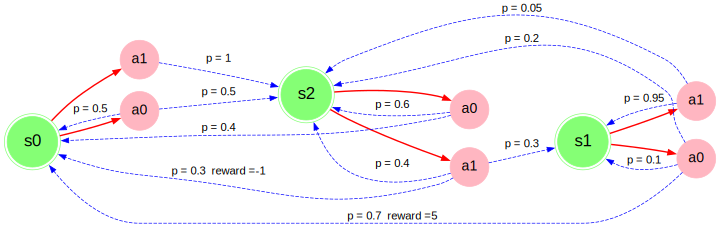

In [8]:
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
    display(plot_graph(mdp))

In [10]:
print(type(mdp))

<class 'mdp.MDP'>


## **Value Iteration**

The simplest algorithm so far is __V__alue __I__teration

Here's the pseudo-code for VI:

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

---

First, let's write a function to compute the state-action value function $Q({\pi})$, defined as follows

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$

Using $Q(s,a)$ we can now define the "next" V(s) for value iteration.
 $$V_{i+1}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

Now let's use those $V_{i+1}(s)$ to find optimal actions in each state

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$
 
The only difference vs V(s) is that here we take not max but argmax: find action such with maximum Q(s,a).

Thus, we now commence by defining a function that will return the action value.


In [14]:
# Compute the Q-value using the formula above
def get_action_value(mdp, state_values, state, action, gamma):

    # Initialise Q 
    Q = 0  
    for s in mdp.get_all_states():
      # Compute Q using the equation above
      Q = Q + mdp.get_transition_prob(state, action, s)*(mdp.get_reward(state, action, s) + \
        gamma*state_values[s]) 
    return Q

We can check the value of the state-value dictionary or the actul Q-values for a couple of sample state-action tuples using the code below

In [15]:
import numpy as np
test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
print(test_Vs)
print(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9))
assert np.isclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
print(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9))
assert np.isclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

{'s0': 0, 's1': 1, 's2': 2}
0.6900000000000002
3.9499999999999997


With the action in hand, we can now define a function to return the state value

In [16]:
def get_new_state_value(mdp, state_values, state, gamma):
    import numpy as np

    # Computes next V(s) as in formula above. Do not change state_values in process.
    if mdp.is_terminal(state):
        return 0

    # Initialise the dict
    A = [a for a in mdp.get_possible_actions(state)]
    v = np.zeros(len(mdp.get_possible_actions(state)))
    i = 0
    
    # Compute all possible options
    for a in mdp.get_possible_actions(state):
      v[i] = get_action_value(mdp, state_values, state, a, gamma)
      A[i] = a
      i = i+1

    # Recover V(s) and π∗(s) as per the formula above
    V = {A[np.argmax(v)]:v[np.argmax(v)]}
    
    return V

In [17]:
test_Vs_copy = dict(test_Vs)
V = get_new_state_value(mdp, test_Vs, 's0', 0.9)
print(test_Vs)
a = list(V)[0]
v = V[a]
print(a, v)
assert np.isclose(v, 1.8)
assert test_Vs == test_Vs_copy, "Please do not change state_values in get_new_state_value"

{'s0': 0, 's1': 1, 's2': 2}
a1 1.8


Finally, let's combine everything we wrote into a working value iteration algorithm

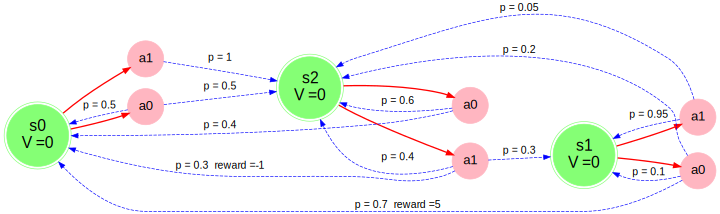

iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000
iter    1   |   diff: 0.64500   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000
iter    2   |   diff: 0.58050   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 0.645
iter    3   |   diff: 0.43582   |   V(s0) = 0.581   V(s1) = 3.959   V(s2) = 0.962
iter    4   |   diff: 0.30634   |   V(s0) = 0.866   V(s1) = 4.395   V(s2) = 1.272
iter    5   |   diff: 0.27571   |   V(s0) = 1.145   V(s1) = 4.670   V(s2) = 1.579
iter    6   |   diff: 0.24347   |   V(s0) = 1.421   V(s1) = 4.926   V(s2) = 1.838
iter    7   |   diff: 0.21419   |   V(s0) = 1.655   V(s1) = 5.169   V(s2) = 2.075
iter    8   |   diff: 0.19277   |   V(s0) = 1.868   V(s1) = 5.381   V(s2) = 2.290
iter    9   |   diff: 0.17327   |   V(s0) = 2.061   V(s1) = 5.573   V(s2) = 2.481
iter   10   |   diff: 0.15569   |   V(s0) = 2.233   V(s1) = 5.746   V(s2) = 2.654
iter   11   |   diff: 0.14012   |   V(s0) = 2.389   V(s1) = 5.902   V(s2) = 2.810
iter   12   |   

In [18]:
# parameters
gamma = 0.9            # discount for MDP
num_iter = 100         # maximum iterations, excluding initialization
# stop VI if new values are this close to old values (or closer)
min_difference = 0.001

# initialize V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

for i in range(num_iter):

    # Compute new state values using the functions defined above.
    # It must be a dict {state : float V_new(state)}
    new_state_values = {}
    for s in mdp.get_all_states():
      nsv = get_new_state_value(mdp, state_values, s, gamma)
      a = list(nsv)[0]
      v = nsv[a]
      new_state_values[s] = v

    assert isinstance(new_state_values, dict)

    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    print("iter %4i   |   diff: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = new_state_values

    if diff < min_difference:
        print("Terminated")
        break

Finally, we can now plot the final graphical model

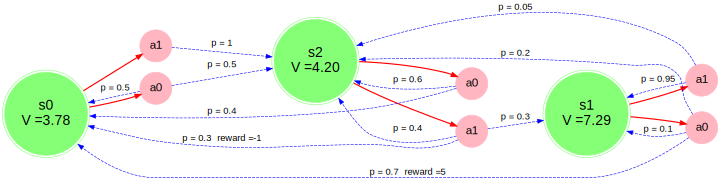

In [19]:
if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

Also, we can now look at te final state values.

In [20]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 3.781) < 0.01
assert abs(state_values['s1'] - 7.294) < 0.01
assert abs(state_values['s2'] - 4.202) < 0.01

Final state values: {'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}



Now let's solve the MDP by finding the optimal action. 

In [21]:
def get_optimal_action(mdp, state_values, state, gamma):
    # Finds optimal action using formula above. 
    if mdp.is_terminal(state):
        return None

    nsv = get_new_state_value(mdp, state_values, state, gamma)
    a = list(nsv)[0]

    return a

In [22]:
gamma=0.9
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a1'


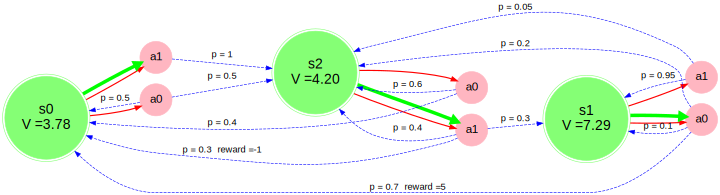

In [23]:
if has_graphviz:
    display(plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value))

In [24]:
# Measure agent's average reward

s = mdp.reset()
rewards = []
gamma=0.9

for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("average reward: ", np.mean(rewards))

assert(0.40 < np.mean(rewards) < 0.55)

average reward:  0.4569
